# Devel
Development scripts, snippets, and other code.

In [4]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../..')

### Example: read images from DSA

In [5]:
# Imports
import numpy as np
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt

from neurotk import login
from neurotk.girder_utils import get_tile_metadata

In [6]:
# Authenticate client.
gc = login('http://glasslab.neurology.emory.edu:8080/api/v1', 
           username='jvizcar')

In [7]:
# Get the an example image.
item = gc.getItem('65088a859a8ab9ec771ba6b3')
item

{'_id': '65088a859a8ab9ec771ba6b3',
 '_modelType': 'item',
 'baseParentId': '65076df80ee4a71d07789e6f',
 'baseParentType': 'collection',
 'copyOfItem': '65076e940ee4a71d07789ea2',
 'created': '2023-09-18T17:36:05.984000+00:00',
 'creatorId': '65076cd6f54b759be7e6933e',
 'description': '',
 'folderId': '650887979a8ab9ec771ba678',
 'largeImage': {'fileId': '65088a869a8ab9ec771ba6b4',
  'sourceName': 'bioformats'},
 'meta': {'Channels': {'Leica/DAPI': 'Astrocytes',
   'Leica/DSRED': 'Nuclei',
   'Leica/EGFP': 'IgM'},
  'Disease': 'Control',
  'annotate': 'yes',
  'note': 'channels mislabelled'},
 'name': '7-27-2023 E20-18 IGHM GFAP.lif',
 'size': 280319297,
 'updated': '2023-09-21T16:20:42.670000+00:00'}

In [8]:
# Get the tile metadata to read the frame info - find the DAPI frame.
tile_metadata = get_tile_metadata(gc, item['_id'])

print('Channel map is the important key.')
tile_metadata

Channel map is the important key.


{'IndexRange': {'IndexC': 3},
 'IndexStride': {'IndexC': 1},
 'bandCount': 1,
 'channelmap': {'Leica/DAPI': 0, 'Leica/DSRED': 2, 'Leica/EGFP': 1},
 'channels': ['Leica/DAPI', 'Leica/EGFP', 'Leica/DSRED'],
 'dtype': 'uint8',
 'frames': [{'Channel': 'Leica/DAPI',
   'Frame': 0,
   'Index': 0,
   'IndexC': 0,
   'IndexT': 0,
   'IndexXY': 0,
   'IndexZ': 0},
  {'Channel': 'Leica/EGFP',
   'Frame': 1,
   'Index': 0,
   'IndexC': 1,
   'IndexT': 0,
   'IndexXY': 0,
   'IndexZ': 0},
  {'Channel': 'Leica/DSRED',
   'Frame': 2,
   'Index': 0,
   'IndexC': 2,
   'IndexT': 0,
   'IndexXY': 0,
   'IndexZ': 0}],
 'levels': 5,
 'magnification': None,
 'mm_x': None,
 'mm_y': None,
 'sizeX': 4186,
 'sizeY': 4212,
 'tileHeight': 512,
 'tileWidth': 512}

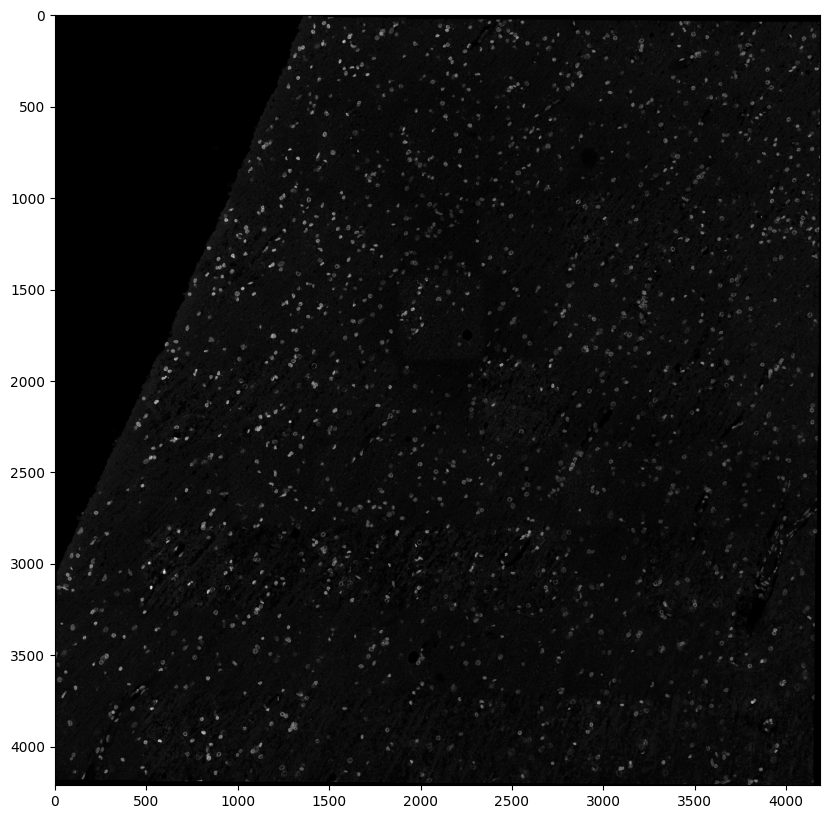

In [9]:
# Get the DAPI image.
response = gc.get(
    f"item/{item['_id']}/tiles/region?units=base_pixels&exact=false&frame=2" + \
    '&encoding=PNG', jsonResp=False
)

img = np.array(Image.open(BytesIO(response.content)))

# Show the image.
plt.figure(figsize=(10,10))
plt.imshow(img, cmap='gray')
plt.show()

### Blob detector

In [34]:
import cv2 as cv
import numpy as np
from skimage.filters import threshold_otsu
from scipy.ndimage import binary_fill_holes

In [51]:
# Subset the previous image.
response = gc.get(
    f"item/65088a859a8ab9ec771ba6b3/tiles/region?units=base_pixels&exact=false&frame=2" + \
    '&encoding=PNG', jsonResp=False
)

img = np.array(Image.open(BytesIO(response.content)))

img = img[:1280, 1280: 1280+1280]

# ret, thresh1 = cv.threshold(img, 120, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)  

# thresh = threshold_otsu(img)

# img = img > thresh

# img = binary_fill_holes(img, structure=np.ones((10,10)))
# img = img.astype(np.uint8) * 255

# plt.imshow(img, cmap='gray')
# plt.show()

In [45]:
# Simple blob detector strategy.
params = cv.SimpleBlobDetector_Params()
params.maxThreshold = 255

detector = cv.SimpleBlobDetector_create(params)

keypoints = detector.detect(img)

print(f'Number of keypoints found: {len(keypoints)}')


Number of keypoints found: 0


In [64]:
# Source: https://scikit-image.org/docs/stable/auto_examples/features_detection/plot_blob.html
from skimage.feature import blob_dog, blob_log, blob_doh
from math import sqrt

# Laplacian of Gaussian
blobs = blob_log(img, max_sigma=30, num_sigma=10, threshold=.1)
blobs[:, 2] = blobs[:, 2] * sqrt(2)

# Different of Gaussian
# blobs = blob_dog(img, max_sigma=30, threshold=.1)
# blobs[:, 2] = blobs[:, 2] * sqrt(2)

# Difference of Hessian
# blobs = blob_doh(img, max_sigma=30, threshold=.01)


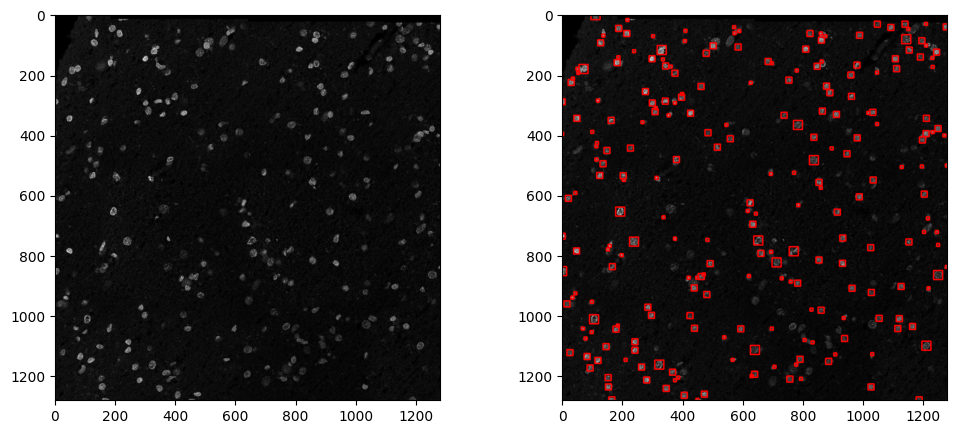

In [69]:
# Draw the circles.
fig = plt.figure(figsize=(12, 5))
fig.add_subplot(1, 2, 1)
plt.imshow(img, cmap='gray')

results = img.copy()
results = cv.cvtColor(results, cv.COLOR_GRAY2RGB)

for blob in blobs:
    y, x, r = blob.astype(int)
    
    if r <= 1:
        continue
    
    x1, y1 = x - r, y - r
    x2, y2 = x + r, y + r
    results = cv.rectangle(results, (x1, y1), (x2, y2), (255, 0, 0), 3)
    
fig.add_subplot(1, 2, 2)
plt.imshow(results)
plt.show()

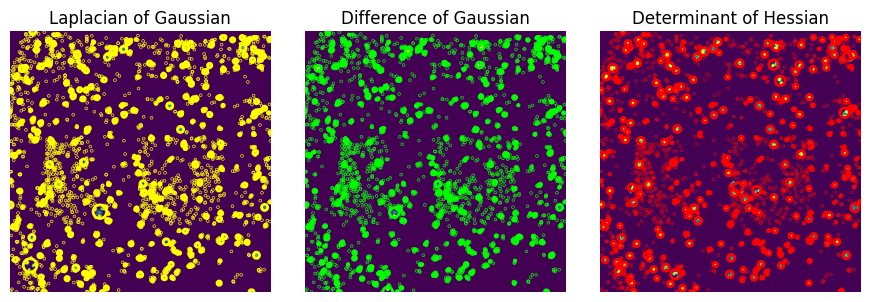

In [50]:
fig, axes = plt.subplots(1, 3, figsize=(9, 3), sharex=True, sharey=True)
ax = axes.ravel()

for idx, (blobs, color, title) in enumerate(sequence):
    ax[idx].set_title(title)
    ax[idx].imshow(img)
    for blob in blobs:
        y, x, r = blob
        c = plt.Circle((x, y), r, color=color, linewidth=2, fill=False)
        ax[idx].add_patch(c)
    ax[idx].set_axis_off()

plt.tight_layout()
plt.show()